In [1]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import cv2
import mediapipe as mp
import time

from modules.model_trainer import ModelTrainer
from modules.model_performance import ModelPerformanceVisualizer
from modules.model_eval import ModelEvaluator
from modules.model_saver import ModelSaver

In [2]:
class HandSignDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.samples = []
        self.class_to_idx = {}
        
        for class_idx, class_name in enumerate(sorted(os.listdir(data_dir))):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = class_idx
                for sample_name in os.listdir(class_dir):
                    if sample_name.endswith('.json'):
                        self.samples.append((os.path.join(class_dir, sample_name), class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path, class_idx = self.samples[idx]
        with open(sample_path, 'r') as f:
            landmarks = json.load(f)
        
        # Convert the list of dictionaries to a flat list of coordinates
        landmarks_flat = [coord for point in landmarks[0] for coord in (point['x'], point['y'], point['z'])]
        
        return torch.tensor(landmarks_flat, dtype=torch.float32), class_idx

    def get_class_names(self):
        return list(self.class_to_idx.keys())

    def get_class_name(self, class_idx):
        for name, idx in self.class_to_idx.items():
            if idx == class_idx:
                return name
        return None  

In [4]:
class HandSignNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HandSignNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
torch.manual_seed(42)

dataset = HandSignDataset('Landmarks_DS')
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
class_names = dataset.get_class_names()
print("All class names:", class_names)

# Get the name of a specific class (e.g., class with index 0)
idx = 24
class_name = dataset.get_class_name(idx)
print(f"Class name for index {dataset.get_class_name(idx)} :", class_name)

All class names: ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Class name for index N : N


d:\SignLanguage\.venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5228 | train_acc: 0.0803 | test_loss: 3.2974 | test_acc: 0.1250 | lr: 0.001000
Epoch: 2 | train_loss: 2.8377 | train_acc: 0.2147 | test_loss: 2.3948 | test_acc: 0.3555 | lr: 0.001000
Epoch: 3 | train_loss: 2.0232 | train_acc: 0.4274 | test_loss: 1.7835 | test_acc: 0.4349 | lr: 0.001000
Epoch: 4 | train_loss: 1.5087 | train_acc: 0.5588 | test_loss: 1.3310 | test_acc: 0.5990 | lr: 0.001000
Epoch: 5 | train_loss: 1.1759 | train_acc: 0.6526 | test_loss: 1.0395 | test_acc: 0.7396 | lr: 0.001000
Epoch: 6 | train_loss: 0.9472 | train_acc: 0.7382 | test_loss: 0.8970 | test_acc: 0.7435 | lr: 0.001000
Epoch: 7 | train_loss: 0.7923 | train_acc: 0.7833 | test_loss: 0.7127 | test_acc: 0.8307 | lr: 0.001000
Epoch: 8 | train_loss: 0.6743 | train_acc: 0.8192 | test_loss: 0.6328 | test_acc: 0.8490 | lr: 0.001000
Epoch: 9 | train_loss: 0.5777 | train_acc: 0.8438 | test_loss: 0.5512 | test_acc: 0.8503 | lr: 0.001000
Epoch: 10 | train_loss: 0.5150 | train_acc: 0.8626 | test_loss: 

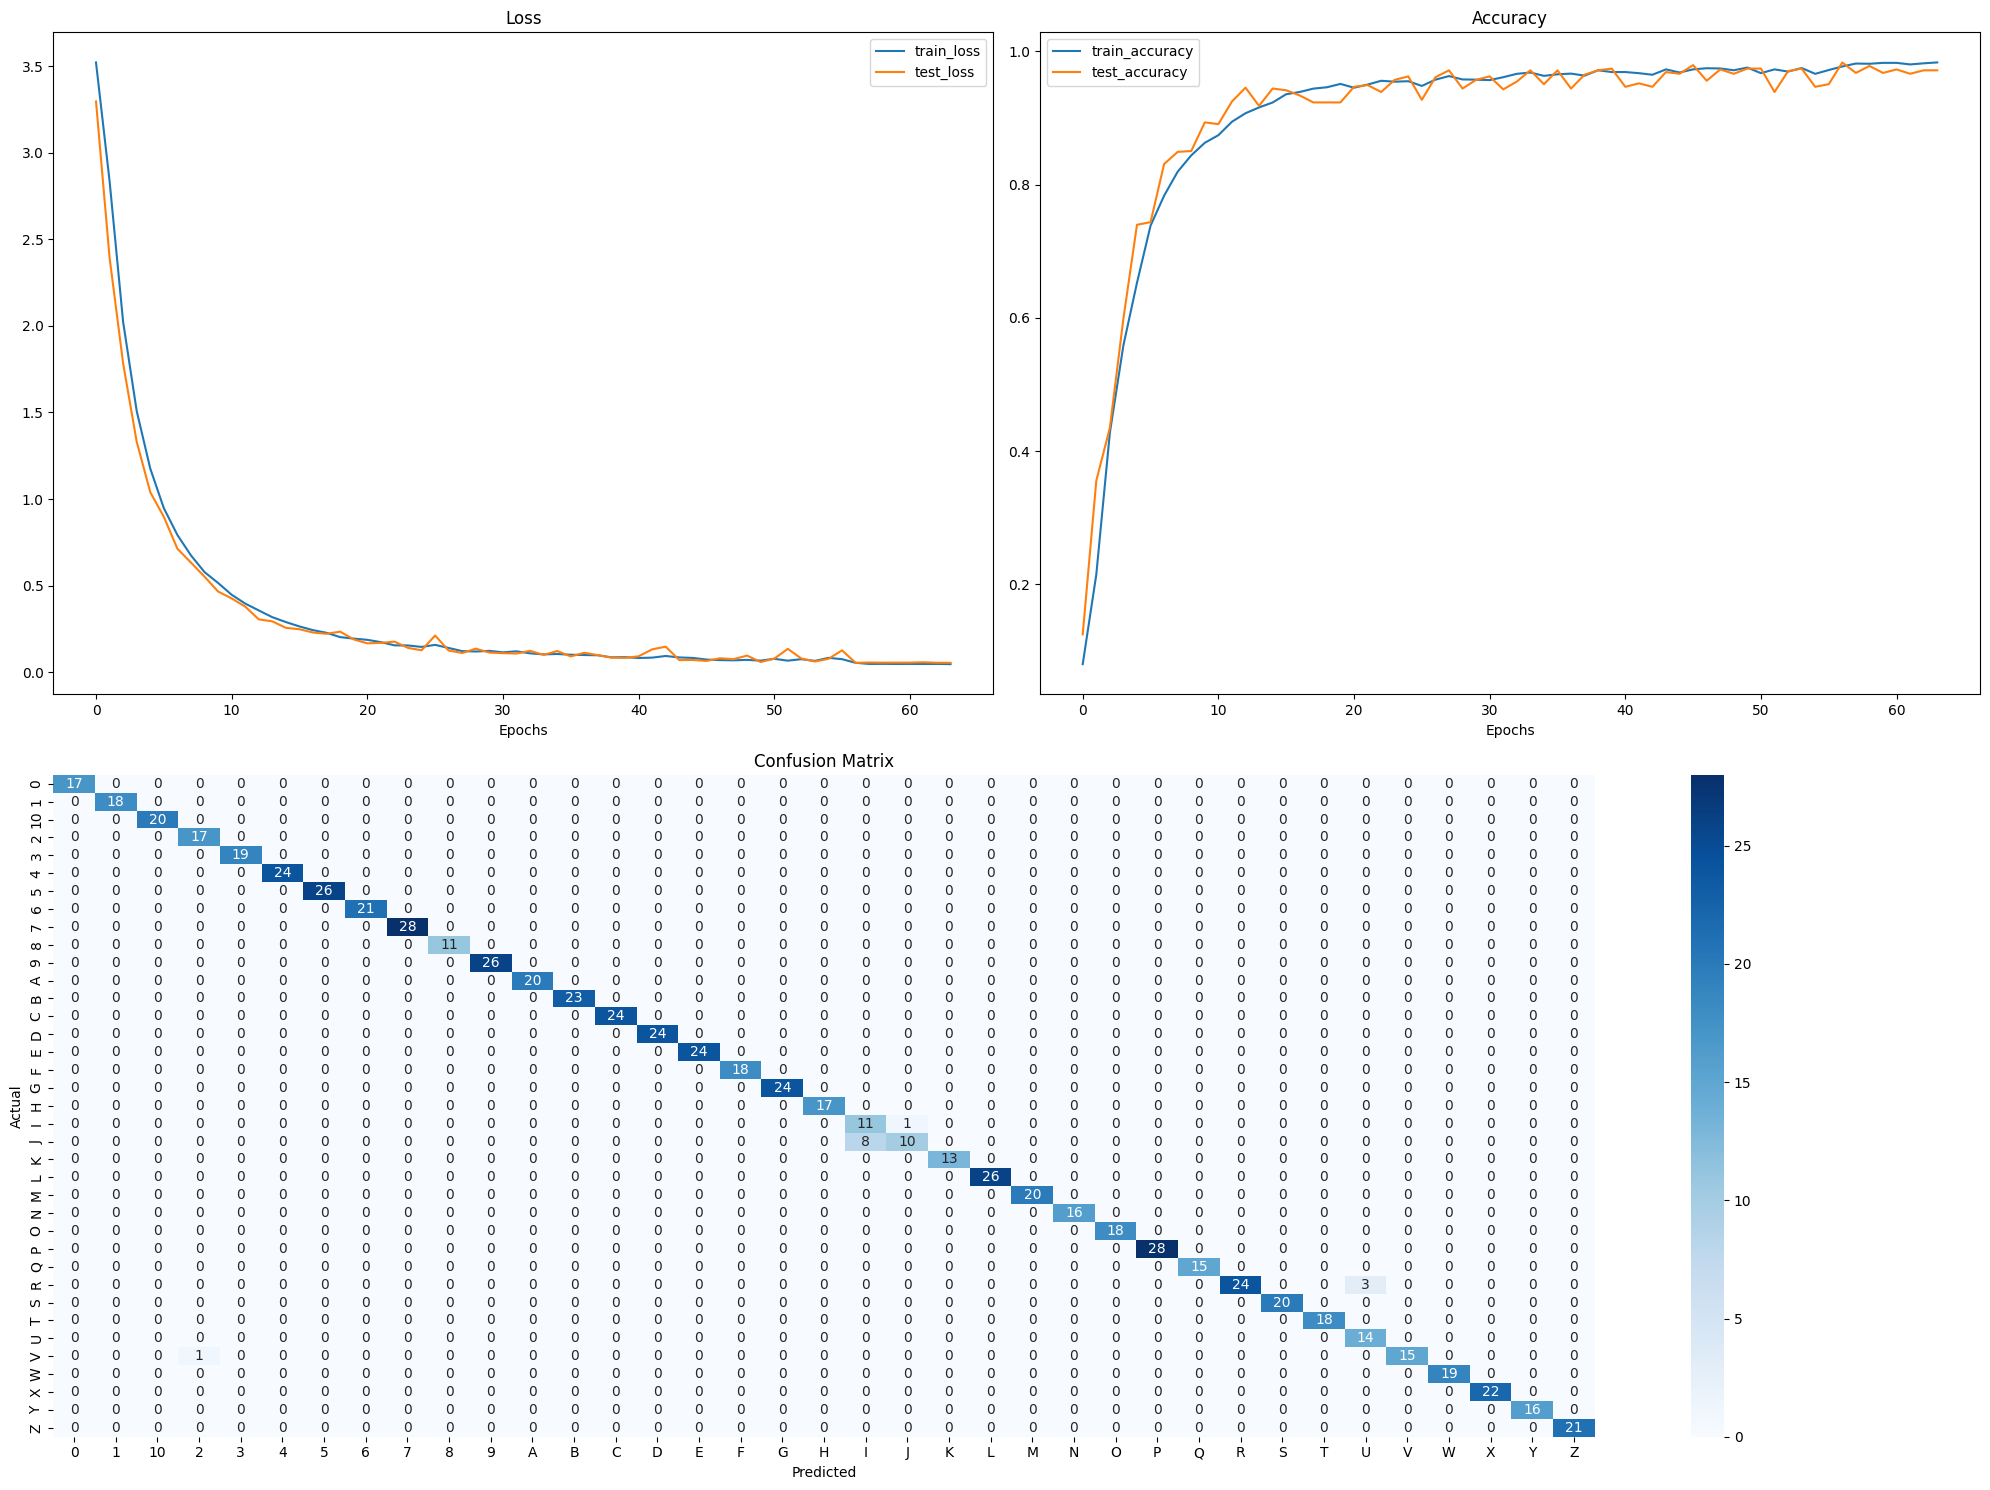

In [7]:
trainer = ModelTrainer()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 21 * 3  
num_classes = len(dataset.class_to_idx)
model = HandSignNet(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

NUM_EPOCHS = 64
EARLY_STOPPING = 7

TRAINED_MODEL, RESULTS = trainer.train(
    model=model,
    train_loader=train_loader,
    test_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=NUM_EPOCHS,
    scheduler=scheduler,
    patience=EARLY_STOPPING 
)

visualizer = ModelPerformanceVisualizer(RESULTS)
y_true, y_pred = visualizer.get_preds(model=TRAINED_MODEL, dataloader=val_loader, device=device)
visualizer.plot_all(y_true=y_true, y_pred=y_pred, classes=class_names, save_path="model_performance/plot.jpg")

In [8]:
saver = ModelSaver(target_dir="models")
saver.save_model(model=model, model_name="landmark_model.pth")

[INFO] Saving model to: models\landmark_model.pth


In [9]:
evaluator = ModelEvaluator(model)
results = evaluator.evaluate_and_report(val_loader, class_names)

print(f"Accuracy: {results['accuracy']:.4f}")
print("Classification Report:")
print(results['classification_report'])

Accuracy: 0.9824
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        20
           2       0.94      1.00      0.97        17
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        26
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        26
           A       1.00      1.00      1.00        20
           B       1.00      1.00      1.00        23
           C       1.00      1.00      1.00        24
           D       1.00      1.00      1.00        24
           E       1.00      1.00      1.00        24
           F       1.00      1.00      1.

In [ ]:
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import numpy as np

# Define the HandSignNet model
class HandSignNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HandSignNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Load the trained model
input_size = 21 * 3  # 21 landmarks, each with x, y, z coordinates
num_classes = 37  # 10 numbers + 26 letters + 1 additional class
model = HandSignNet(input_size, num_classes)
model.load_state_dict(torch.load("models/landmark_model.pth"))
model.eval()

# Define the classes
classes = [str(i) for i in range(1, 11)] + [chr(i) for i in range(ord('A'), ord('Z') + 1)] + ['Other']

# Print model information
print(f"Model loaded. Number of output classes: {num_classes}")
print(f"Number of classes in the 'classes' list: {len(classes)}")
print("\nPress 'q' to quit the inferencing.")

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame from webcam")
        break

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the image and detect hands
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Prepare input for the model
            landmarks = []
            for landmark in hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])

            # Make prediction
            input_tensor = torch.FloatTensor(landmarks).unsqueeze(0)
            with torch.no_grad():
                output = model(input_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                _, predicted = torch.max(output, 1)
                
                # Debug information
                print(f"Raw output: {output}")
                print(f"Probabilities: {probabilities}")
                print(f"Predicted index: {predicted.item()}")

                # Get predicted class
                predicted_class = classes[predicted.item()]

            # Display the predicted class
            cv2.putText(frame, f"Predicted: {predicted_class}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Hand Sign Recognition', frame)

    # Add quit instruction to the frame
    cv2.putText(frame, "Press 'q' to quit", (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Quitting inferencing...")
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
hands.close()

print("Inference completed. Resources released.")